<a href="https://colab.research.google.com/github/No1Talent/DLSelfDrivingCars/blob/master/Self_Driving_Car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Prep

## Pack and Data Import

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import models,transforms,datasets # handling deep learning models, image transformations, and datasets

import csv
from torch.utils.data import random_split


from toolkit import * # store network architectures

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [7]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/MyDrive/')

%pwd

Mounted at /content/gdrive


'/content/gdrive/MyDrive'

In [8]:
import csv
from torch.utils.data import random_split

samples = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        samples.append(line)

# Split the data into training and validation sets
train_len = int(0.8 * len(samples))
train_samples, validation_samples = random_split(samples, [train_len, len(samples) - train_len])

In [9]:
# samples.head
len(samples), samples[:1]

(8036,
 [['IMG/center_2016_12_01_13_30_48_287.jpg',
   ' IMG/left_2016_12_01_13_30_48_287.jpg',
   ' IMG/right_2016_12_01_13_30_48_287.jpg',
   ' 0',
   ' 0',
   ' 0',
   ' 22.14829']])

In [10]:
data = pd.read_csv('data/driving_log.csv')
data.head()
# data.iloc[1]

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


## Balanced Sampling

In [ ]:
# First, identify the indices where steering is 0
zero_steering_indices = data[data['steering'] == 0].index

# Calculate the number of indices to drop (30% of the total zero steering data)
num_indices_to_drop = int(0.5 * len(zero_steering_indices))

# Randomly select indices to drop
indices_to_drop = np.random.choice(zero_steering_indices, size=num_indices_to_drop, replace=False)

# Drop the selected indices from the DataFrame
data_ds = data.drop(indices_to_drop)

<Axes: xlabel='steering', ylabel='Count'>

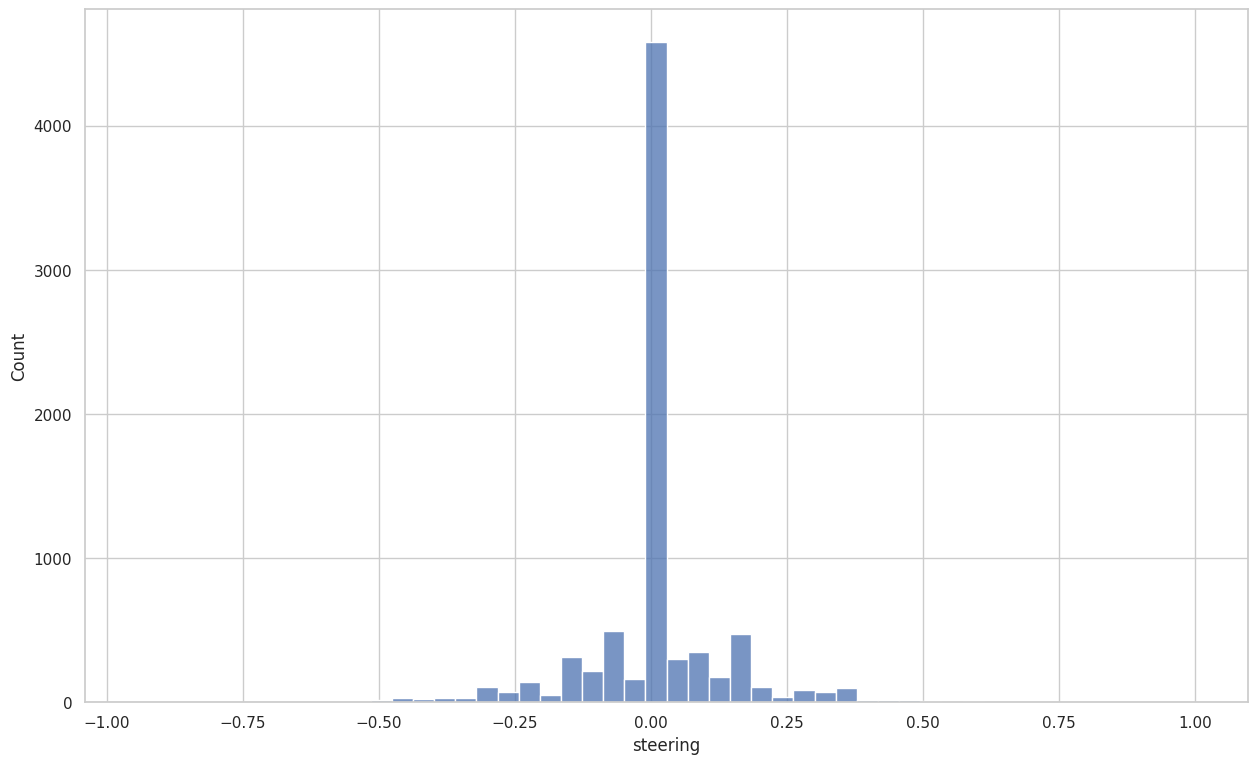

In [ ]:
# data["steering"].describe()
# plt.hist(data["steering"])
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style = 'whitegrid')
plt.figure(figsize = (15,9))
sns.histplot(data["steering"], bins = 50)

<Axes: xlabel='steering', ylabel='Count'>

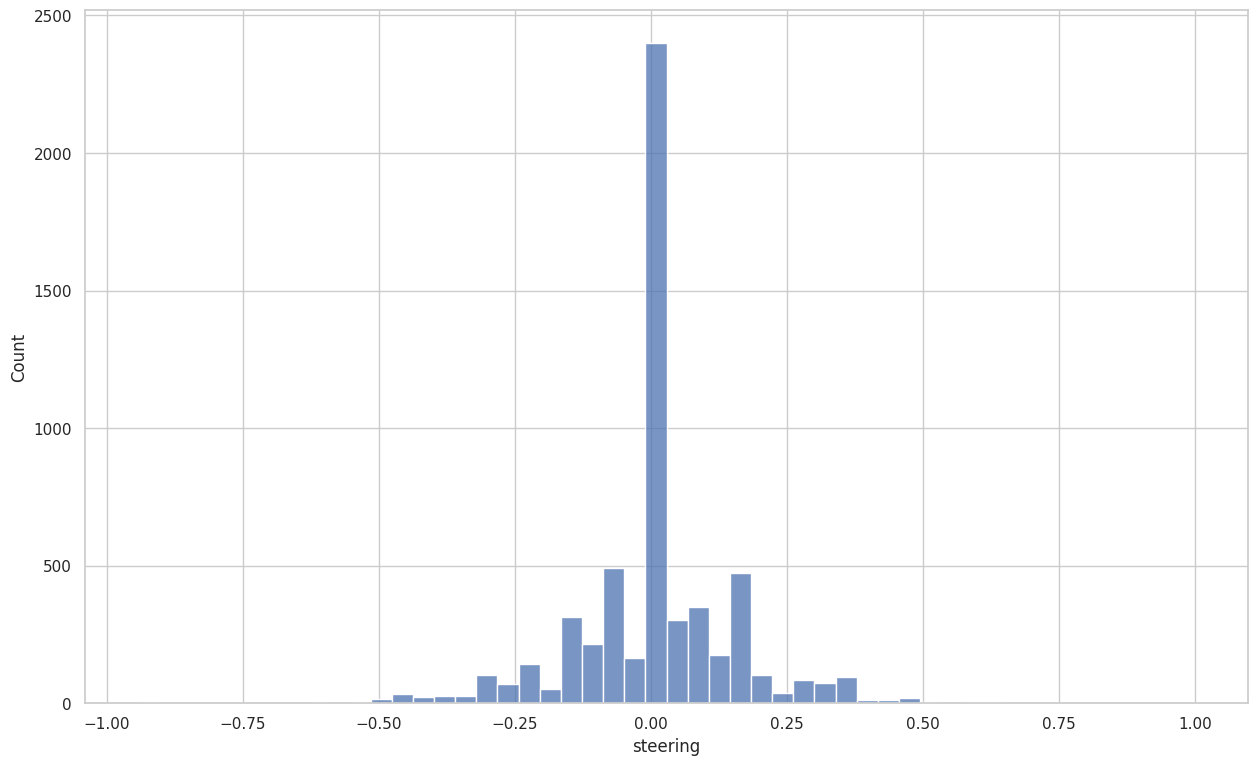

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style = 'whitegrid')
plt.figure(figsize = (15,9))
sns.histplot(data_ds["steering"], bins = 50)

# Image Preprocessing and Augmentation

[reference](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py)

In [11]:
from torchvision.io import read_image

def path_to_img(img_path):
  img_path = str(img_path)
  img = read_image(f'data/IMG/{img_path.split("/")[-1]}')
  return img

def cropping(img):
  img = img[:, 20:55, :] #picture-level
  # img = img[: ,60:140, :] # batch-level [RGB0:3, row_from:to, col_from: to]

In [31]:
from torchvision import models,transforms,datasets
from torchvision.transforms import v2

transformations = v2.Compose([
    v2.ToTensor(),  # Convert to tensor, only needed if you had a PIL image
    # v2.ToDtype(torch.uint8, scale=True),  # input are already uint8
    v2.Resize(size=(66,200), antialias=True), # v2.RandomResizedCrop(size=(224, 224), antialias=True)
    v2.RandomHorizontalFlip(p=0.5),
    # v2.RandomResizedCrop(size=(66, 200), scale=(0.8, 1.0), ratio=(0.75, 1.333), interpolation=2, antialias=True),
    v2.ToDtype(torch.float32, scale=True)  # Normalize expects float input
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # to improve GPU processing speed
])
# antialias=True to smooth the edges of images or graphics to reduce aliasing artifacts, such as jagged edges or flickering


'''
import torchvision.transforms as transforms
transformations = transforms.Compose([transforms.Lambda(lambda x: (x / 255.0) - 0.5)])
'''

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


'\nimport torchvision.transforms as transforms\ntransformations = transforms.Compose([transforms.Lambda(lambda x: (x / 255.0) - 0.5)])\n'

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to display images
# overwrite plt.imshow
def imshow(img, title=None, normalization = False):
  img = img.numpy().transpose((1, 2, 0))
  if normalization:
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
  img = np.clip(img,0,1)
  # Clipping input data to the valid range for imshow with RGB data
  # [0,1] for floats or [0,255] for integers
  plt.imshow(img)
  if title is not None:
    plt.title(title)

In [14]:
# sum it up
'''
def random_flip(img, angle):
  if np.random.rand() < 0.5:
    img = cv2.flip(img, 1)
    angle = -angle
  return img, angle

    if np.random.rand() < 0.5:
    img, angle = random_flip(img, angle)
'''

def random_augment(img, angle):
  v2.RandomHorizontalFlip(p=0.5)
  if np.random.rand() < 0.5:
    jitter = v2.ColorJitter(brightness=.5, hue=.3)
    img = jitter(img)
  if np.random.rand() < 0.5:
    blurrer = v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))
    img = blurrer(img)
  return img, angle

# Dataset Loading and Batching

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader

class CarImageDataset(Dataset):
    def __init__(self, samples, transform = None, crop = None, augment = None):
      self.samples = samples
      self.transform = transform # function default to = None, not = False
      self.augment = augment
      self.crop = crop

    def __getitem__(self, index):
      # get a batch
      batch_samples = self.samples[index]
      # read-in Y
      steering_angle = float(batch_samples[3])
      # read-in X
      center_img, left_img, right_img = batch_samples[:3]
      # img_path to img
      center_img, left_img, right_img = path_to_img(center_img), path_to_img(left_img),path_to_img(right_img)
      # randomly augment X
      if self.augment:
          center_img,angle_center = self.augment(center_img, steering_angle)
          left_img,angle_left = self.augment(left_img, steering_angle + 0.4)
          right_img,angle_right = self.augment(right_img, steering_angle - 0.4 )
      else:
        angle_center = steering_angle
        angle_left = steering_angle + 0.4
        angle_right = steering_angle - 0.4
      # crop here: raise Runtime Error...
      # cropping
      if self.crop:
        center_img, left_img, right_img = self.crop(center_img), self.crop(left_img), self.crop(right_img)
      # transform
      center_img, left_img, right_img = self.transform(center_img), self.transform(left_img), self.transform(right_img)

      return (center_img, angle_center), (left_img, angle_left), (right_img, angle_right)

    def __len__(self):
      return len(self.samples)


In [58]:
dset_train = CarImageDataset(train_samples, transform = transformations)
loader_train = DataLoader(dset_train, batch_size=64, shuffle=True, num_workers=2)
# params = {'batch_size': 32, 'shuffle': True, 'num_workers': 4}
# loader_train = data.DataLoader(dset_train, **params)

dset_valid = CarImageDataset(validation_samples, transform = transformations)
loader_valid = DataLoader(dset_valid, batch_size=64, shuffle=False, num_workers=2)

# , crop = cropping, augment = random_augment

# get a batch for testing and plotting

In [34]:
next(iter(enumerate(loader_train)))

(0,
 [[tensor([[[[0.4667, 0.4667, 0.4667,  ..., 0.4353, 0.4353, 0.4353],
             [0.4745, 0.4745, 0.4745,  ..., 0.4431, 0.4431, 0.4431],
             [0.4902, 0.4902, 0.4902,  ..., 0.4471, 0.4471, 0.4471],
             ...,
             [0.3765, 0.3882, 0.4118,  ..., 0.4196, 0.3569, 0.3333],
             [0.3765, 0.3765, 0.3725,  ..., 0.3804, 0.3765, 0.3451],
             [0.3765, 0.3961, 0.4314,  ..., 0.3725, 0.3922, 0.3647]],
   
            [[0.5804, 0.5804, 0.5804,  ..., 0.5451, 0.5451, 0.5451],
             [0.5882, 0.5882, 0.5882,  ..., 0.5529, 0.5529, 0.5529],
             [0.6039, 0.6039, 0.6039,  ..., 0.5569, 0.5569, 0.5569],
             ...,
             [0.3804, 0.3922, 0.4157,  ..., 0.4235, 0.3608, 0.3373],
             [0.3804, 0.3804, 0.3765,  ..., 0.3843, 0.3804, 0.3490],
             [0.3804, 0.4000, 0.4353,  ..., 0.3765, 0.3961, 0.3686]],
   
            [[0.7529, 0.7529, 0.7529,  ..., 0.6980, 0.6980, 0.6980],
             [0.7608, 0.7608, 0.7608,  ..., 0.7059, 0

In [12]:
# get a batch for plotting
(center_img, steering_angle_center), (left_img, steering_angle_left), (right_img, steering_angle_right) = next(iter(loader_train))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

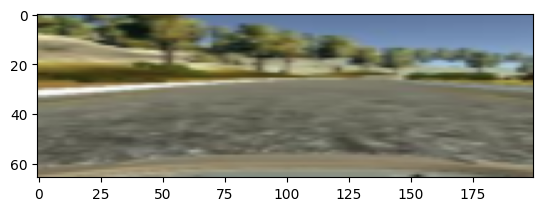

In [13]:
imshow(center_img[0])

In [14]:
center_img.shape, center_img[0].shape
# [batch_size, RGB, H, W]
# (3 x H x W)

(torch.Size([64, 3, 66, 200]), torch.Size([3, 66, 200]))

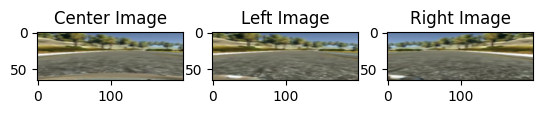

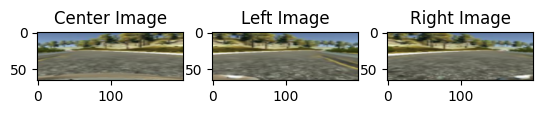

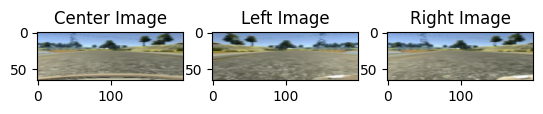

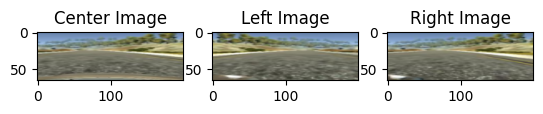

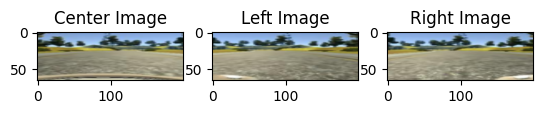

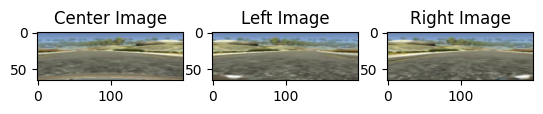

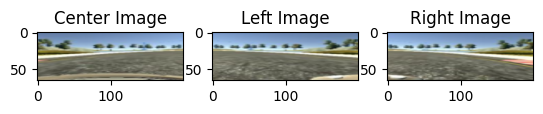

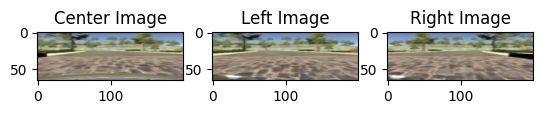

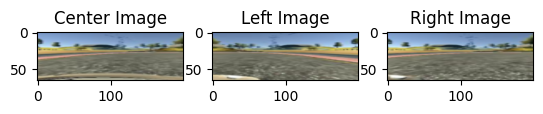

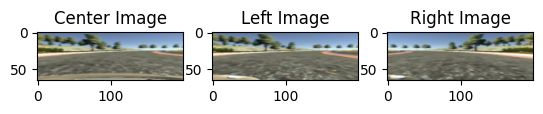

In [15]:
# Visualize the batch of images
for i in range(10): # len(center_img)
    # Display Center Image
    plt.subplot(1, 3, 1)
    imshow(center_img[i], title="Center Image")

    # Display Left Image
    plt.subplot(1, 3, 2)
    imshow(left_img[i], title="Left Image")

    # Display Right Image
    plt.subplot(1, 3, 3)
    imshow(right_img[i], title="Right Image")

    plt.show()

# Model Architecture
- Adapted NVIDIA Model
    
- Light Model


## Functions to facilitate layer building

In [17]:
def cal_CNN_output_size(input_height, input_width, K, S = 1, P = 0):
    """
    Calculate the output size of a convolutional layer.
    Returns:
    - tuple: Tuple representing the output size (height, width).
    """

    output_height = ((input_height - K + 2 * P) / S) + 1
    output_width = ((input_width - K + 2 * P) / S) + 1

    return int(output_height), int(output_width)
    #

def cal_MP_output_size(input_height, input_width, K, S = 1, P = 0):
    output_height = (input_height - K) // S + 1
    output_width = (input_width - K) // S + 1
    return int(output_height), int(output_width)

## Adapted Nvidia Model
    - the convolution layers are meant to handle feature engineering
    - the fully connected layer for predicting the steering angle.
    - dropout avoids overfitting
    - ELU(Exponential linear unit) function takes care of the Vanishing gradient problem.

![title](https://www.researchgate.net/profile/Mathew-Monfort/publication/301648615/figure/fig4/AS:357938163142666@1462350516717/CNN-architecture-The-network-has-about-27-million-connections-and-250-thousand.png)

In [42]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F

class NvidiaModel(nn.Module):
    def __init__(self):
        super(NvidiaModel, self).__init__()
        # Imput images: 3@66*200
        # Conv Layers (W1, W2, F, S = 1, P = 0)
        # output_size = (W - F + 2P)/S + 1
        self.conv1 = nn.Conv2d(3, 24, 5, 2) # 24@31*98
        self.conv2 = nn.Conv2d(24, 36, 5, 2) # 36@14*47
        self.conv3 = nn.Conv2d(36, 48, 5, 2) # 48@5*22
        self.conv4 = nn.Conv2d(48, 64, 3) #64@2*20
        self.conv5 = nn.Conv2d(64, 64, 3) #64@1*18
        self.dropout1 = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*1*18, 100)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, 50)
        self.dropout3 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(50, 10)
        self.dropout4 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = F.elu(self.conv5(x))
        x = self.dropout1(x)
        x = self.flatten(x)
        x = F.elu(self.fc1(x))
        x = self.dropout2(x)
        x = F.elu(self.fc2(x))
        x = self.dropout3(x)
        x = F.elu(self.fc3(x))
        x = self.dropout4(x)
        x = self.fc4(x)
        return x

In [52]:
model = NvidiaModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

## Light Net 1 DL

proposed by

In [20]:
cal_CNN_output_size(66, 200, 3, 2)
cal_CNN_output_size(32, 99, 3,2)

(15, 49)

In [21]:
cal_MP_output_size(15, 49, 4, 2)

(6, 23)

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class NetworkLight(nn.Module):
    def __init__(self):
        super(NetworkLight, self).__init__()
        # Imput images: 3@66*200
        # Conv Layers (W1, W2, F, S = 1, P = 0)
        # output_size = (W - F + 2P)/S + 1

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 24, kernel_size=3, stride=2) # 24@32*99
        self.conv2 = nn.Conv2d(24, 48, kernel_size=3, stride=2) # 48@15*49
        self.pool = nn.MaxPool2d(kernel_size=4, stride=4) # 48@6*23
        self.dropout = nn.Dropout(p=0.25)
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=48*6*23, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=10)
        self.fc3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, input):
        input = input.view(input.size(0), 3, 66, 200)
        output = F.elu(self.conv1(input))
        output = F.elu(self.conv2(output))
        output = self.pool(output)
        output = self.dropout(output)

        output = output.view(output.size(0), -1)
        output = F.elu(self.fc1(output))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

In [23]:
model_l = NetworkLight()
optimizer = optim.Adam(model_l.parameters(), lr=0.001)
criterion = nn.MSELoss()

## Light Net 2 Paper


In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F

class NvidiaModel(nn.Module):
    def __init__(self):
        super(NvidiaModel, self).__init__()
        # Imput images: 3@66*200
        # Conv Layers (W1, W2, F, S = 1, P = 0)
        # output_size = (W - F + 2P)/S + 1
        self.conv1 = nn.Conv2d(3, 24, 5, 2) # 24@31*98
        self.conv2 = nn.Conv2d(24, 36, 5, 2) # 36@14*47
        self.conv3 = nn.Conv2d(36, 48, 5, 2) # 48@5*22
        self.conv4 = nn.Conv2d(48, 64, 3) #64@2*20
        self.conv5 = nn.Conv2d(64, 64, 3) #64@1*18
        self.dropout1 = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*1*18, 100)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, 50)
        self.dropout3 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(50, 10)
        self.dropout4 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = F.elu(self.conv5(x))
        x = self.dropout1(x)
        x = self.flatten(x)
        x = F.elu(self.fc1(x))
        x = self.dropout2(x)
        x = F.elu(self.fc2(x))
        x = self.dropout3(x)
        x = F.elu(self.fc3(x))
        x = self.dropout4(x)
        x = self.fc4(x)
        return x

# Training and Validation Loop

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def to_device(data, device):
  imgs, angles = data
  return imgs.float().to(device), angles.float().to(device)

max_epochs = 2
model.to(device)

train_losses = []
valid_losses = []

for epoch in range(max_epochs):
  # Training
  train_loss = 0.0
  model.train()
  for local_batch, (centers, lefts, rights) in enumerate(loader_train):
    centers, lefts, rights = to_device(centers, device), to_device(lefts, device), to_device(rights, device)
    for data in [centers, lefts, rights]:
      imgs, angles = data
      outputs = model(imgs)
      loss = criterion(outputs, angles.unsqueeze(1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    avg_train_loss = train_loss / ((local_batch + 1) * 3)
    train_losses.append(avg_train_loss)

  # Validation
  model.eval()
  valid_loss = 0.0

  with torch.no_grad():
    for local_batch, (centers, lefts, rights) in enumerate(loader_valid):
      centers, lefts, rights = to_device(centers, device), to_device(lefts, device), to_device(rights, device)

    for data in [centers, lefts, rights]:
        imgs, angles = data
        outputs = model(imgs)
        loss = criterion(outputs, angles.unsqueeze(1))
        valid_loss += loss.item()

    avg_valid_loss = valid_loss / ((local_batch + 1) * 3)
    valid_losses.append(avg_valid_loss)

    print(f"Epoch [{epoch+1}/{max_epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}")


NameError: ignored

## Hyperparameter Tunning

optimize epochs_options, lr_options, and weight_decay_options

In [24]:
import torch

def find_optimal_hyperparameters(model, criterion, train_loader, valid_loader, device, epochs_options, lr_options, weight_decay_options=[0]):
    best_val_loss = float('inf')
    best_hyperparameters = None
    best_checkpoint = None

    for weight in weight_decay_options:
        for lr in lr_options:
            for epochs in epochs_options:
                print(f"Training with weight decay: {weight}, learning rate: {lr}, epochs: {epochs}")

                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight)
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)

                train_losses, valid_losses, early_stop = train(model, optimizer, scheduler, criterion, train_loader, valid_loader, device, epochs)

                final_val_loss = valid_losses[-1]
                if final_val_loss < best_val_loss:
                    best_val_loss = final_val_loss
                    best_hyperparameters = {
                        'epoch_size': epochs,
                        'learning_rate': lr,
                        'weight_decay': weight,
                        'early_stop_epoch': len(valid_losses) if early_stop else epochs
                    }
                    # Save the checkpoint
                    best_checkpoint = {
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'hyperparameters': best_hyperparameters,
                        'best_val_loss': best_val_loss
                    }
                    torch.save(best_checkpoint, 'checkpoint.pth')

    return best_checkpoint

NameError: ignored

# Performance Evaluation


• Value loss or Accuracy (computed during training phase)
• Generalization on Track 1 (drive performance)
Value loss or Accuracy
The first evaluation parameter considered here is “Loss” over each epoch of the training run.
To calculate value loss over each epoch, Keras provides “val_loss”, which is the average loss
after that epoch. The loss observed during the initial epochs at the beginning of training phase
is high, but it falls gradually, and that is evident by the screenshots below which shows the
run of Architecture in the training phase

## MSE plot

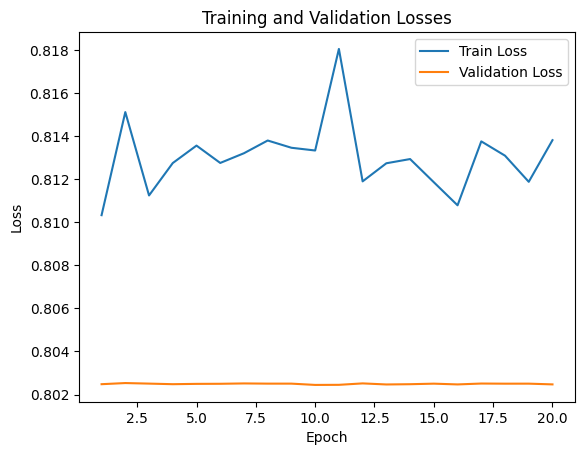

In [36]:
import matplotlib.pyplot as plt


epochs = range(1, max_epochs + 1)


plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save Model to disk

In [ ]:
state = {
        'model': model.module if device == 'cuda' else model,
        }

torch.save(state, 'model.h5')